#  Формирование модели монетизации

<h2><font color="blue">Mобильная игра «Космические братья»🚀 </font><a class="tocSkip"></a></h2>


<font size="3" color="green"> **Об игре:** </font>

В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.
В данный момент, в игре отсутствует монетизация, она только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.
В датасете представлены данные по игре пользователей на первом уровне.

Завершение первого уровня требует от игрока выполнения одного из двух условий:
* победа над первым врагом;
* реализация проекта - разработка орбитальной сборки спутников.

<font size="3">❗</font>В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно. Согласно данным менеджера, предположительный доход от показа рекламы составит 0,07$.

<font size="3" color="green"> **Цель:** </font>

Провести исследование и сформировать модель монетизации игрового приложения.

<font size="3" color="green">**Задачи**:</font>
1. Изучение данных:
* загрузка и предобработка данных;
2. Исследовательский анализ данных.
3. Проверка гипотез:
* гипотеза №1 Время прохождения уровней различается;
* гипотеза №2 Вовлеченность игроков не зависит от канала привлечения;
4. Итоги:
* вывод по исследованию;
* рекомендации по формированию модели монетизации.

Дополнительные материалы к анализу:
* дашборд;
* презентация(<a href="https://disk.yandex.ru/i/2uOBfpC2-_Tejw">тыц</a>  <a href="https://drive.google.com/file/d/18OUm7vd8VVIuldWH5McdPMM6nCR5pIu7/view?usp=sharing"> или тут</a>)

# Импорт библиотек, загрузка данных, определение функций

In [1]:
#импортируем библиотеки и параметры
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy import stats as st
import datetime

warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', None)
sns.set(rc={'figure.figsize':(15,6)})
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#загрузим данные в переменные
try:
    game_actions = pd.read_csv('../final/game_actions.csv')
    ad_cost = pd.read_csv('../final/ad_costs.csv')
    user_source = pd.read_csv('../final/user_source.csv')
except: 
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    ad_cost = pd.read_csv('/datasets/ad_costs.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')   

In [3]:
#функцие будем передавать датасет, в цикле будем перебирать столбцы
def dataset_info(dataset):
    count = 0
    dataset.columns = dataset.columns.str.lower().str.replace(' ','_') #тут приведем название столбцов к snake_case
    for column in dataset.columns:
        count += 1
        print('Название столбца:     ',column)                          #покажет как называется столбец
        print('Длина столбца:        ',len(dataset[column]))            #отобразит длину столбца
        print('Количество пропусков: ',dataset[column].isna().sum())    #отобразит количество пропусков
        print('Тип данных в столбце: ',dataset[column].dtype)           #покажет тип данных в столбце
        print('Число уникальных значений: ',dataset[column].nunique())  #отобразит количество уникальных значений 
        print('Пример значений:      ')                                 
        print(dataset[column].unique())                                 #отобразит уникальные значения
        print('----------------')
    print('Всего столбцов в датасете:', count)                          #подсчитаем количество столбцов в датасете
    print('Количество дубликатов: ',dataset.duplicated().sum())         #подсчитает количество полных строк-дубликатов

In [4]:
#функция для визуализации данных посредством гистограммы
def barplot_create(x,y,table,title,xl,yl,cm, rot):
    ax = sns.barplot(x=x, y=y, data=table, dodge=True)
    for p in ax.patches:
        height = p.get_height()
        ax.text(x = p.get_x()+(p.get_width()/2),
                y = height+cm,
                s = '{:.2f}'.format(height),
                ha = 'center')
    plt.xticks(rotation=rot)
    plt.title(title, fontsize = 20)
    plt.xlabel(xl)
    plt.ylabel(yl);

In [5]:
#функция для визуализации данных посредством тепловой карты
def heatmap_create(table,title,xl,yl,fmt):
    plt.figure(figsize=(20, 15))
    plt.title(title, size=20)
    ax = sns.heatmap(table, annot=True, fmt=fmt, linewidths=1, linecolor='gray', \
                     cbar=0,square=True, cmap="YlGnBu")
    plt.xlabel(xl, size=15)
    plt.ylabel(yl, size=15)
    plt.show()

## Предобработка данных

### Датасет game_actions

Датасет game_actions.csv:
* `event_datetime` — время события;
* `event` — одно из трёх событий:
1. building — объект построен,
2. finished_stage_1 — первый уровень завершён,
3. project — проект завершён;
* `building_type` — один из трёх типов здания:
1. assembly_shop — сборочный цех,
2. spaceport — космопорт,
3. research_center — исследовательский центр;
* `user_id` — идентификатор пользователя;
* `project_type` — тип реализованного проекта.

In [6]:
game_actions.sample(5) #выведем 5 случайных строк датасета

,event_datetime,event,building_type,user_id,project_type
80716,2020-05-11 06:49:02,building,spaceport,b11d067c-04d3-4a42-b75a-0bb781579630,NaN
67402,2020-05-10 06:59:15,building,assembly_shop,6cc0824f-15d6-4cdf-a99f-768aa90706e0,NaN
95398,2020-05-13 02:49:41,project,NaN,663cc3d7-91a2-4dde-aa27-d8bb80c8b092,satellite_orbital_assembly
74993,2020-05-10 18:50:45,building,spaceport,e42c840c-f8a4-4994-8ed9-52590f60d03b,NaN
29103,2020-05-07 04:27:17,building,assembly_shop,22a495fc-f27b-4da3-a0ae-bac35e1829af,NaN


In [7]:
dataset_info(game_actions) #применим функцию и получим информацию

Название столбца:      event_datetime
Длина столбца:         135640
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  128790
Пример значений:      
['2020-05-04 00:00:01' '2020-05-04 00:00:03' '2020-05-04 00:00:16' ...
 '2020-06-05 08:57:52' '2020-06-05 12:12:27' '2020-06-05 12:32:49']
----------------
Название столбца:      event
Длина столбца:         135640
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  3
Пример значений:      
['building' 'finished_stage_1' 'project']
----------------
Название столбца:      building_type
Длина столбца:         135640
Количество пропусков:  7683
Тип данных в столбце:  object
Число уникальных значений:  3
Пример значений:      
['assembly_shop' 'spaceport' nan 'research_center']
----------------
Название столбца:      user_id
Длина столбца:         135640
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  13576
Пример значений:      
['55e92310-cb8e-4

В датасете `game_actions` 135640 строк и 5 столбцов:
* `event_datetime` - пропусков не имеется, тип данных необходимо привести к *datetime*;
* `event` - пропусков не имеется, тип данных корректный, имеет всего 3 значения;
* `building_type` - имеется 7683 пропуска, тип данных корректный;
* `user_id` - пропусков нет, тип данных корректный, имеем данные по 13576 пользователям;
* `project_type` - 133774 пропуска, тип данных корректный. В силу специфики настройки системы сбора данных, пропуски обусловлены отсутствием реализованного проекта, поэтому данные пропуски оставляем без изменений;

также имеется лишь одна строка дубликат.

Для начала поменяем тип данных в `event_datetime` и проверим результат

In [8]:
#поменяем тип данных в столбце
game_actions['event_datetime']=pd.to_datetime(game_actions['event_datetime'])
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


По результат проверки, мы выявили одну строку-дубликат. Удалим ее и проверим результат.

In [9]:
#удалим дубликаты строк
game_actions=game_actions.drop_duplicates()

In [10]:
#проверим результат удаления
game_actions.duplicated().sum() 

0

### Датасет ad_cost

Датасет ad_cost.csv содержит колонки:
* `day` - день, в который был совершен клик по объявлению;
* `source` - источник трафика;
* `cost` - стоимость кликов.

In [11]:
ad_cost.sample(5) #выведем 5 случайных строк датасета

,source,day,cost
0,facebook_ads,2020-05-03,935.88
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77
7,instagram_new_adverts,2020-05-03,943.20


In [12]:
dataset_info(ad_cost) #применим функцию и получим информацию

Название столбца:      source
Длина столбца:         28
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  4
Пример значений:      
['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']
----------------
Название столбца:      day
Длина столбца:         28
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  7
Пример значений:      
['2020-05-03' '2020-05-04' '2020-05-05' '2020-05-06' '2020-05-07'
 '2020-05-08' '2020-05-09']
----------------
Название столбца:      cost
Длина столбца:         28
Количество пропусков:  0
Тип данных в столбце:  float64
Число уникальных значений:  28
Пример значений:      
[935.88278612 548.35447985 260.18575416 177.98220002 111.76679631
  68.00927645  38.72335021 943.2047174  502.92545098 313.97098369
 173.07114531 109.91525421  71.57873946  46.7753997  969.13939394
 554.65149408 308.23298964 180.91709941 114.42933758  62.96162991
  42.77950457 454.22494283 259.0732

В датасете `ad_cost` 3 столбца и всего 28 строк. Пропусков нет, дубликатов тоже не обнаружили. В столбце `day` приведем тип данных к *datetime*.

In [13]:
ad_cost['day']=pd.to_datetime(ad_cost['day'])
ad_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


### Датасет user_source

Датасет user_source.csv содержит колонки:
* `user_id` - идентификатор пользователя;
* `source` - источников, с которого пришёл пользователь, установивший приложение.

In [14]:
user_source.sample(5) #выведем 5 случайных строк датасета

,user_id,source
5969,6f9125f4-4b65-42a5-865d-af131eeb2128,yandex_direct
3954,48dba2e1-5338-4377-bf10-85a2deb611cc,facebook_ads
1377,18f34d97-4c5b-4762-a650-c92ace04e575,yandex_direct
4791,58dc4944-27df-4990-b653-0b017862b1ea,instagram_new_adverts
6192,7360b8dd-5e5d-45bd-85f4-7db0a3e1930e,youtube_channel_reklama


In [15]:
dataset_info(user_source) #применим функцию и получим информацию

Название столбца:      user_id
Длина столбца:         13576
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  13576
Пример значений:      
['0001f83c-c6ac-4621-b7f0-8a28b283ac30'
 '00151b4f-ba38-44a8-a650-d7cf130a0105'
 '001aaea6-3d14-43f1-8ca8-7f48820f17aa' ...
 'fffb626c-5ab6-47c9-8113-2062a2f18494'
 'ffff194a-56b7-4c12-860d-3485242ae7f5'
 'ffff69cc-fec1-4fd3-9f98-93be1112a6b8']
----------------
Название столбца:      source
Длина столбца:         13576
Количество пропусков:  0
Тип данных в столбце:  object
Число уникальных значений:  4
Пример значений:      
['facebook_ads' 'yandex_direct' 'youtube_channel_reklama'
 'instagram_new_adverts']
----------------
Всего столбцов в датасете: 2
Количество дубликатов:  0


В датасете `user_source` всего 2 столбца и 13576 строк, пропусков и дубликатов не обнаружили, типы данных соответствуют.

user_source.groupby('source')['user_id'].count().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.xlabel("Источник", fontsize= 12)
plt.ylabel("Количество игроков", fontsize= 12)
plt.title("Количество пользователей по источникам привлечения", fontsize= 15);

### Вывод

**Датасет game_actions:**

В датасете на момент изучения данных было 135640 строк и 5 столбцов:
* `event_datetime` - пропусков не имеется, тип данных необходимо привести к *datetime*;
* `event` - пропусков не имеется, тип данных корректный, имеет всего 3 значения;
* `building_type` - имеется 7683 пропуска, тип данных корректный;
* `user_id` - пропусков нет, тип данных корректный, имеем данные по 13576 пользователям;
* `project_type` - 133774 пропуска, тип данных корректный.

В процессе, мы обнаружили одну строку-дубликат, удалили ее. Теперь датасет состоит из 135639 строк и 5 столбцов. Также привели тип данных в `event_datetime` к *datetime*.


**Датасет ad_cost**

Датасет состоит из 28 строк и 3 столбцов:
* `day` - приведем тип данных к *datetime*, содержит уникальных 7 значений;
* `source` - пропусков не имеется, тип данных корректный, содержит 4 уникальных значения;
* `cost` - пропусков не имеется, тип данных корректный.

После анализа данного датасета, привели тип данных в `day` к *datetime*.

**Датасет user_source**
Датасет состоит из 2 столбцов и 13576 строк:
* `user_id` - пропусков не имеется, тип данных корректный;
* `source` - пропусков не имеется, тип данных корректный.

В целом можно заключить, что данные в хорошем состоянии.

## Исследование данных

### Игроки

Узнаем, какое количество игроков есть в наших данных. По условиям к данным, закончившими 1 уровень, можно считать игроков, которые победили над первым врагом или реализавали проект, подсчитаем сколько таких игроков.

In [16]:
#создадим датасет с подсчетом игроков по способу победы
win_or_not = pd.DataFrame({'attribute': ['all_gamers', 'win', 'no_win','pvp','project'], \
        'value': [game_actions['user_id'].nunique(), game_actions.query('event== "finished_stage_1"')['event'].count(),\
                  game_actions['user_id'].nunique()-game_actions.query('event== "finished_stage_1"')['event'].count(),\
                  game_actions.query('event== "finished_stage_1"')['event'].count()-game_actions['project_type'].count(),\
                  game_actions['project_type'].count()]})
win_or_not

,attribute,value
0,all_gamers,13576
1,win,5817
2,no_win,7759
3,pvp,3951
4,project,1866


In [17]:
#подсчитаем общее количество игроков
print('Всего игроков: {:.0f}'.format(win_or_not.iloc[0]['value']))

Всего игроков: 13576


In [18]:
#подсчитаем количество игроков, которые прошли первый уровень и нет
print('Количество игроков, которые прошли уровень: {:.0f}'.format(win_or_not.iloc[1]['value']))
print('Количество игроков, которые НЕ прошли уровень: {:.0f}'.format(win_or_not.iloc[2]['value']))
print('Всего игроков, прошедших 1 уровень: {:.2f}%'.format(win_or_not.iloc[1]['value']/win_or_not.iloc[0]['value']*100))

Количество игроков, которые прошли уровень: 5817
Количество игроков, которые НЕ прошли уровень: 7759
Всего игроков, прошедших 1 уровень: 42.85%


In [19]:
#подсчитаем количество игроков, победивших врага
print('Количество игроков, которые достигли уровня победой над врагом: {:.0f}'.format(win_or_not.iloc[3]['value']))
#подсчитаем количество игроков, построивших проект
print('Количество игроков, которые достигли уровня постройкой орбитальной сборки: {:.0f}'.format(win_or_not.iloc[4]['value']))

Количество игроков, которые достигли уровня победой над врагом: 3951
Количество игроков, которые достигли уровня постройкой орбитальной сборки: 1866


Визуализируем полученную информацию

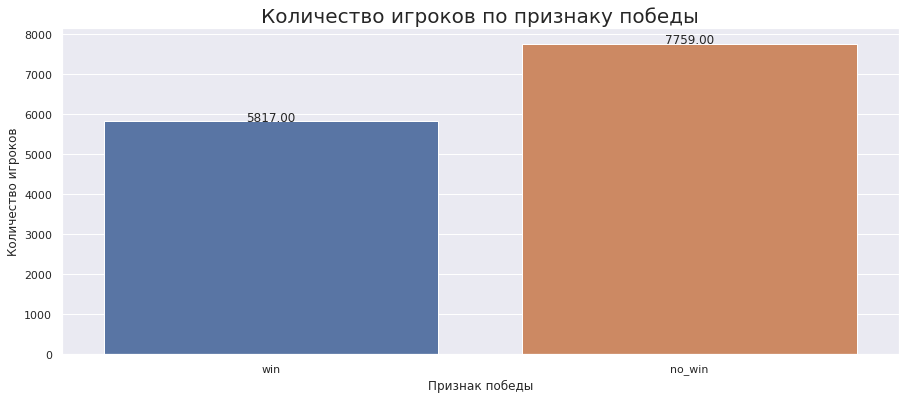

In [20]:
#функцие отправим данные для визуализации
barplot_create('attribute','value',win_or_not.loc[1:2],'Количество игроков по признаку победы',\
               'Признак победы','Количество игроков',1,0)

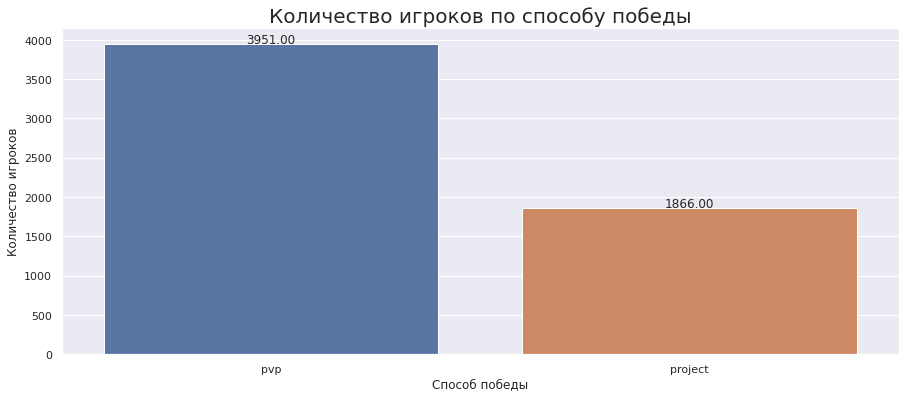

In [21]:
#функцие отправим данные для визуализации
barplot_create('attribute','value',win_or_not.loc[3:],'Количество игроков по способу победы',\
               'Способ победы','Количество игроков',1,0)

Из 13576 игроков, 42.85% (5817 игроков) завершили 1 уровень. Из них завершили уровень победой над врагом: 3951, а постройкой орбитальной сборки: 1866. То есть игроки предпочитаю победу над врагому постройке орбитальной сборки.

### Время прохождения уровня

Неваломажным моменто является время прохождения уровня, подсчитаем и его

In [22]:
users_lvl_time = game_actions[game_actions['event'] == 'finished_stage_1']['user_id'] #отфильтруем выигрывших игроков
lvl_time = (game_actions
              .query('user_id in @users_lvl_time')
              .groupby('user_id')
              .agg({'event_datetime':['min','max']}))               #создадим сводную таблицу с временем прохождения уровня
lvl_time['level_time'] = lvl_time[('event_datetime', 'max')]\
                        - lvl_time[('event_datetime', 'min')]  #определим время выигрыша уровня
#level_time.columns = level_time.columns.droplevel(1)
lvl_time = lvl_time.reset_index().sort_values(by='level_time')
lvl_time.head()

user_id      event_datetime  \
                                                           min   
91    03990bc0-47b6-44ce-9f8b-3afb1a97d0e7 2020-05-07 16:40:32   
4687  ced7b368-818f-48f6-9461-2346de0892c5 2020-05-04 00:13:21   
4547  c8180f71-68dc-4fd5-ba6e-ba5f5d0d28f7 2020-05-08 16:08:29   
825   2204ae7f-892b-494d-bd58-28816ff35eb5 2020-05-07 02:25:27   
1032  2ab1cc5a-413a-408e-ba76-01de8e12bead 2020-05-05 13:25:04   

                              level_time  
                     max                  
91   2020-05-08 02:19:33 0 days 09:39:01  
4687 2020-05-04 19:47:29 0 days 19:34:08  
4547 2020-05-09 11:52:33 0 days 19:44:04  
825  2020-05-08 01:02:51 0 days 22:37:24  
1032 2020-05-06 13:43:12 1 days 00:18:08

In [23]:
#выведем результат подсчета
print('Самое быстрое прохождения уровня за:',lvl_time['level_time'].min())
print('Самое долго время прохождения уровня:',lvl_time['level_time'].max())
print('Среднее время прохождения уровня:',lvl_time['level_time'].mean())
print('Медианное время прохождения уровня:',lvl_time['level_time'].median())

Самое быстрое прохождения уровня за: 0 days 09:39:01
Самое долго время прохождения уровня: 30 days 21:58:53
Среднее время прохождения уровня: 11 days 20:37:59.561801616
Медианное время прохождения уровня: 11 days 13:28:44


Самым быстрым прохождением является победа за 9 часов и 39 минут! На самое долгое, понадобился месяц - 30 дней 20 часов и 58 минут. В среднем же, уровень проходят за 11 дней, 20 часов и 37 минут.

Теперь подчистаем эти показатели для каждой из групп, которые выбрали разные способы прохождения.

In [24]:
#найдем игроков прошедших уровень
user_finish = game_actions[(game_actions['event'] == 'finished_stage_1')][['user_id','event']]
#найдем игроков, прошедших уровень через реализацию проекта
user_project = game_actions[game_actions['event'] == 'project'][['user_id','event']]

In [25]:
#найдем игроков, прошедших уровень чечезе врага
user_enemy = user_finish[~user_finish.isin(user_project['user_id'].unique())].dropna()

In [26]:
#дабавил к таблице с временем прохождения наши две таблицы с user_d
level_project = lvl_time[['user_id', 'level_time']].merge(user_project, how='left', on='user_id').dropna()
level_enemy = lvl_time[['user_id', 'level_time']].merge(user_enemy, how='left', on='user_id').dropna()

In [27]:
#поправим наименование столбцов
level_project.columns=['user_id','user_id_','level_time', 'win']
level_enemy.columns=['user_id','user_id_','level_time', 'win']

In [28]:
#выведем результат подсчета
print('Время прохождения уровня через реализацию проекта:')
print('самое быстрое:',level_project['level_time'].min())
print('самое долгое:',level_project['level_time'].max())
print('среднее время:',level_project['level_time'].mean())
print('медианное время:',level_project['level_time'].median())

Время прохождения уровня через реализацию проекта:
самое быстрое: 5 days 03:22:27
самое долгое: 29 days 03:13:43
среднее время: 13 days 11:00:49.135048231
медианное время: 13 days 00:45:41


In [29]:
#выведем результат подсчета
print('Время прохождения уровня через победу над врагом:')
print('самое быстрое:',level_enemy['level_time'].min())
print('самое долгое:',level_enemy['level_time'].max())
print('среднее время:',level_enemy['level_time'].mean())
print('медианное время:',level_enemy['level_time'].median())

Время прохождения уровня через победу над врагом:
самое быстрое: 0 days 09:39:01
самое долгое: 30 days 21:58:53
среднее время: 11 days 02:30:24.076183244
медианное время: 10 days 19:01:37


In [30]:
#соберем в датафрейм для простоты сравнения
df = pd.DataFrame({'how': ['all', 'wia_project', 'wia_enemy'], \
        'min': [lvl_time['level_time'].min(), level_project['level_time'].min(), level_enemy['level_time'].min()], \
        'max': [lvl_time['level_time'].max(), level_project['level_time'].max(), level_enemy['level_time'].max()],\
        'mean': [lvl_time['level_time'].mean(), level_project['level_time'].mean(), level_enemy['level_time'].mean()],\
        'median': [lvl_time['level_time'].median(), level_project['level_time'].median(), level_enemy['level_time'].median()]}) 


In [31]:
df

,how,min,max,mean,median
0,all,0 days 09:39:01,30 days 21:58:53,11 days 20:37:59.561801616,11 days 13:28:44
1,wia_project,5 days 03:22:27,29 days 03:13:43,13 days 11:00:49.135048231,13 days 00:45:41
2,wia_enemy,0 days 09:39:01,30 days 21:58:53,11 days 02:30:24.076183244,10 days 19:01:37


* Самое быстрое врмея прохождения: получается черезе врага (9 часов 39 минут). Однако через реализацию проекта этот срок составляет - 5 дней 3 часа и 22 минуты.
* Самое долгое время прохождения: через врага (30 дней 21 час 58 минут), вто время как через проект - 29 дней 3 часа 13 минут.
* Среднее время прохождения: составляет 11 дней 20 часов 37 минут, если рассматривать через методы победы, то через врага - 11 дней 2 часа 30 минут, через проект несколько дольше - 13 дней 11 часов.
* Медианное время прохождения: 11 дней 13 часов 28 минут, черезе врага - 10 дней 19 часов 1 минута, через проект - 13 дней 45 минут.

### Количество построек

Подсчитаем сколько зданий и каких видов построили игроки за игровую сессию.

In [32]:
#подсчитаем количество построенных зданий
print('Всего посторили зданий:',game_actions.query('event=="building"')['user_id'].count())

Всего посторили зданий: 127956


In [33]:
#подсчитаем среднее количество построенных зданий для одного игрока
print('Среднее количество построек для одного игрока:',game_actions.query('event=="building"')['user_id'].count()/\
     win_or_not.iloc[0]['value'])

Среднее количество построек для одного игрока: 9.425162050677667


Узнав общее количество построенных зданий, посмотрим каких типов и сколько было построено. Затем визуализируем полученную информацию.

In [34]:
#подсчитаем какие здания и в каком количестве были построены
bldng_type = game_actions['building_type'].value_counts().to_frame(name='value').reset_index()
bldng_type

,index,value
0,spaceport,59325
1,assembly_shop,54494
2,research_center,14137


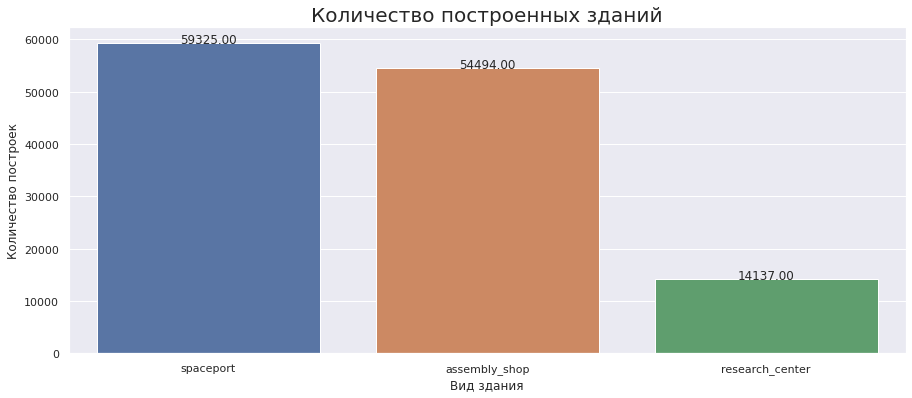

In [35]:
#функцие отправим данные для визуализации
barplot_create('index','value',bldng_type,'Количество построенных зданий',\
               'Вид здания','Количество построек',1,0)

Также подсчитаем количество реализованных проектов:

In [36]:
#подчистаем количество преоктов
print('Количество проектов: {:.0f}'.format(win_or_not.iloc[4]['value']))

Количество проектов: 1866


Всего за игровую сессию, игроки построили 127956 построек, и реализовали 1866 проектов. В разрезе построек, мы увидели, что больше всего строили `spaceport` - 59325 раз, `assembly_shop`- 54494 раз, меньше всего `research_center` - 14137.

После анализа, можно даже сформировать поведение усредненного игрока:
* скорее всего пройдет 1 уровень используя стратегию победы над врагом;
* сделает он это дней так, за 11-12;
* при этом построит много построек типа spaceport и assembly_shop.

### DAU, WAU, Sticky Factor

Определим пользовательскую активность — количество уникальных активных пользователей за определённое время.
В нашем конкретном случае, мы определим:
* *DAU* — количество уникальных пользователей в день;
* *WAU* — количество уникальных пользователей в неделю.

In [37]:
#добавим в датасет данные о дате и номере недели
game_actions['event_date']  = game_actions['event_datetime'].dt.date
game_actions['event_week']  = game_actions['event_datetime'].dt.week

In [38]:
#рассчитаем среднее количество уникальных пользователей в день
dau_total = game_actions.groupby('event_date').agg({'user_id': 'nunique'}).mean()
print('Среднее количество уникальных игроков в день (DAU): {:.2f}'.format(list(dau_total)[0]))

Среднее количество уникальных игроков в день (DAU): 2884.88


Теперь же представим количество уникальных игроков по дням

In [39]:
#количество уникальных игроков по дням
game_actions.groupby('event_date').agg({'user_id': 'nunique'})

,user_id
event_date,
2020-05-04,5860
2020-05-05,6382
2020-05-06,6854
2020-05-07,7384
2020-05-08,7891
2020-05-09,8394
2020-05-10,9219
2020-05-11,5995
2020-05-12,5776


И визуализируем это

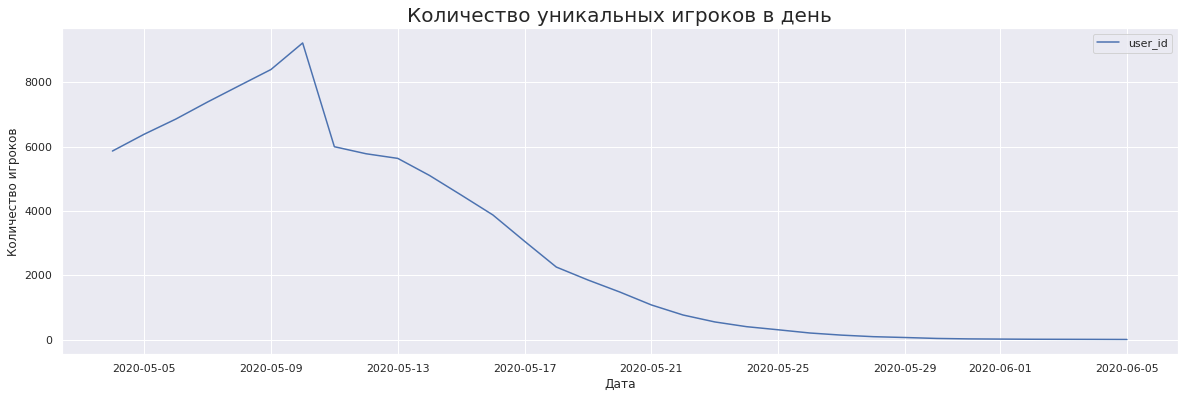

In [40]:
#визуализируем DAU
game_actions.groupby('event_date').agg({'user_id': 'nunique'}).\
plot(figsize=(20, 6), grid=True, rot=0, legend=True)
plt.title('Количество уникальных игроков в день', fontsize = 20)
plt.xlabel('Дата')
plt.ylabel('Количество игроков')
plt.show()

Из визуализации видно, что с 2020-05-04 наблюдается резкий рост, с пиком 2020-05-10. Следом мы наблюдаем резкий спад с 9219 до 	5995 игроков. 2020-05-19 количество игроков становится уже 1852, и скаждым днем все меньше и меньше.

Рассчитаем WAU — количество уникальных пользователей в неделю:

In [41]:
#рассчитаем среднее количество пользователей в неделю
wau_total = game_actions.groupby('event_week').agg({'user_id': 'nunique'}).mean()
print('Среднеем количество уникальных игроков в неделю (WAU): {:.2f}'.format(list(wau_total)[0]))

Среднеем количество уникальных игроков в неделю (WAU): 6120.00


Теперь взглянем на количество уникальных пользователей по неделям

In [42]:
#количество уникальных игроков по неделям
game_actions.groupby('event_week').agg({'user_id': 'nunique'})

,user_id
event_week,
19,13576
20,12121
21,4353
22,521
23,29


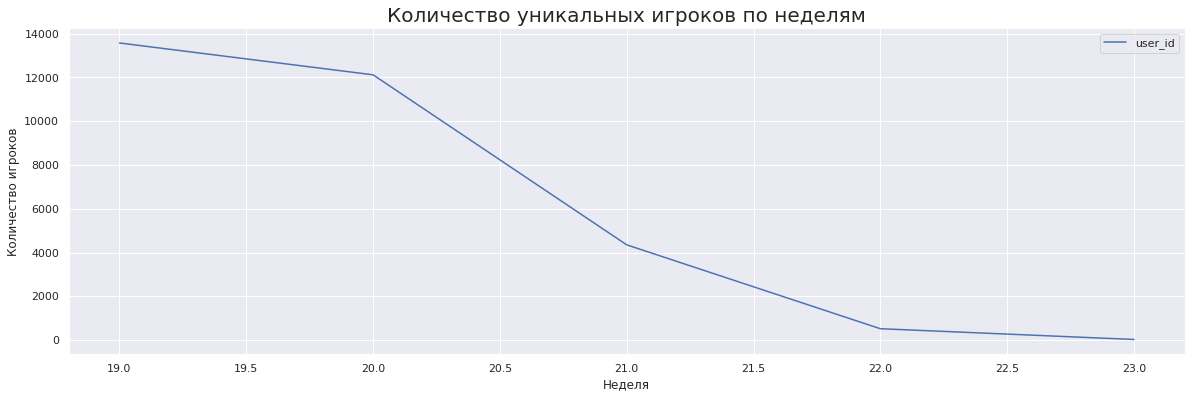

In [43]:
#визуализируем WAU
game_actions.groupby('event_week').agg({'user_id': 'nunique'}).\
plot(figsize=(20, 6), grid=True, rot=0)
plt.title('Количество уникальных игроков по неделям', fontsize = 20)
plt.xlabel('Неделя')
plt.ylabel('Количество игроков')
plt.show()

График показывает нам, что на 19 неделе мы наблюдаем максимальное количество (13576) уникальных игроков, на 20й неделе чуть меньше - 12121 игроков, затем, начиная с 21 недели - наблюдаем резкое падение в количество уникальных пользователей.

Ещё одна популярная метрика — sticky factor, или «липкий фактор» в переводе с английского. Sticky factor отражает регулярность использования сервиса или приложения и для недельной аудитории рассчитывается как DAU/WAU.

In [44]:
sticky_week = int(dau_total) / int(wau_total)
print('Регулярность использования игры составляет: {:.2%}'.format(sticky_week))

Регулярность использования игры составляет: 47.12%


Мы определили показатели DAU, WAU, а также Sticky Factor:
* **DAU** (количество уникальных пользователей в день) равен **2884.88** игроков;
* **WAU** (количество уникальных пользователей в неделю) равен **6120.00** игроков;
* **Sticky Factor** (регулярность использования) находится на уровне **47.12%**

Визуализировав DAU, мы увидели, что с 2020-05-04 наблюдается резкий рост, с пиком 2020-05-10. Следом мы наблюдаем резкий спад с 9219 до 5995 игроков. 2020-05-19 количество игроков становится уже 1852, и скаждым днем все меньше и меньше.

Также дела обстоят и с WAU, график с каждой неделей ниспадает. На 19 неделе мы наблюдаем максимальное количество (13576) уникальных игроков, на 20й неделе чуть меньше - 12121 игроков, затем, начиная с 21 недели - наблюдаем резкое падение в количестве уникальных пользователей.

### Retention Rate

Теперь определим такой показатель, как Retention Rate, он показывает, сколько пользователей из когорты относительно их изначального числа вернулись, то есть воспользовались продуктом или услугой, в последующие периоды.

Для начала, необходмо для каждого пользователя найти самую раннюю дату события, ее мы будет считать первой.

In [45]:
#сгруппируем по пользователю и найдем первую дату события
frts_dt=game_actions.groupby('user_id').agg({'event_date': 'min'}).reset_index()
frts_dt.columns=['user_id','first_date']
frts_dt.head()

,user_id,first_date
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05


Затем добавим эту дату в основной датасет, также рассчитаем лайфтайм игрока.

In [46]:
#соединим таблицу по игроку
game_actions=game_actions.merge(frts_dt,on='user_id', how='left')

In [47]:
#рассчитаем лайфтайм
game_actions['lifetime']=game_actions['event_date']-game_actions['first_date']

Сформируем сводную таблицу по первой дате игрока и его лайфтайму

In [48]:
#сводная таблица по дате и лайфтайму
result_grouped = game_actions.pivot_table(
    index=['first_date'], columns='lifetime', values='user_id', aggfunc='nunique'
)
result_grouped

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,22 days,23 days,24 days,25 days,26 days,27 days,28 days,29 days,30 days,31 days
first_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,"5,860.00","3,021.00","3,204.00","3,412.00","3,564.00","3,758.00","4,161.00","2,728.00","2,504.00","2,379.00",...,43.00,29.00,19.00,12.00,6.00,4.00,2.00,1.00,2.00,2.00
2020-05-05,"3,361.00","1,803.00","1,903.00","2,058.00","2,133.00","2,312.00","1,589.00","1,516.00","1,374.00","1,280.00",...,23.00,16.00,9.00,8.00,3.00,2.00,1.00,NaN,NaN,NaN
2020-05-06,"1,847.00",960.00,"1,018.00","1,118.00","1,224.00",802.00,820.00,803.00,686.00,614.00,...,9.00,10.00,4.00,3.00,3.00,4.00,1.00,1.00,1.00,NaN
2020-05-07,"1,109.00",563.00,613.00,665.00,424.00,444.00,510.00,433.00,365.00,323.00,...,11.00,7.00,3.00,6.00,3.00,3.00,3.00,3.00,NaN,NaN
2020-05-08,688.00,332.00,375.00,242.00,262.00,285.00,303.00,259.00,180.00,215.00,...,3.00,5.00,1.00,NaN,2.00,1.00,NaN,NaN,NaN,NaN
2020-05-09,440.00,211.00,141.00,149.00,192.00,172.00,185.00,168.00,119.00,95.00,...,3.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-10,271.00,69.00,81.00,89.00,92.00,112.00,118.00,100.00,57.00,57.00,...,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сформируем когорты по дням

In [49]:
#сформируем когорты по дням
cohort_sizes = (
    game_actions.groupby('first_date').agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
cohort_sizes

,cohort_size
first_date,
2020-05-04,5860
2020-05-05,3361
2020-05-06,1847
2020-05-07,1109
2020-05-08,688
2020-05-09,440
2020-05-10,271


Теперь добавим размер когорты в основую таблицу с количеством уникальных игроков по дням

In [50]:
#добавим размер когорты для последующих вычислений
result_grouped = cohort_sizes.merge(
    result_grouped, on='first_date', how='left'
).fillna(0)
result_grouped

,cohort_size,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00,8 days 00:00:00,...,22 days 00:00:00,23 days 00:00:00,24 days 00:00:00,25 days 00:00:00,26 days 00:00:00,27 days 00:00:00,28 days 00:00:00,29 days 00:00:00,30 days 00:00:00,31 days 00:00:00
first_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,5860,"5,860.00","3,021.00","3,204.00","3,412.00","3,564.00","3,758.00","4,161.00","2,728.00","2,504.00",...,43.00,29.00,19.00,12.00,6.00,4.00,2.00,1.00,2.00,2.00
2020-05-05,3361,"3,361.00","1,803.00","1,903.00","2,058.00","2,133.00","2,312.00","1,589.00","1,516.00","1,374.00",...,23.00,16.00,9.00,8.00,3.00,2.00,1.00,0.00,0.00,0.00
2020-05-06,1847,"1,847.00",960.00,"1,018.00","1,118.00","1,224.00",802.00,820.00,803.00,686.00,...,9.00,10.00,4.00,3.00,3.00,4.00,1.00,1.00,1.00,0.00
2020-05-07,1109,"1,109.00",563.00,613.00,665.00,424.00,444.00,510.00,433.00,365.00,...,11.00,7.00,3.00,6.00,3.00,3.00,3.00,3.00,0.00,0.00
2020-05-08,688,688.00,332.00,375.00,242.00,262.00,285.00,303.00,259.00,180.00,...,3.00,5.00,1.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00
2020-05-09,440,440.00,211.00,141.00,149.00,192.00,172.00,185.00,168.00,119.00,...,3.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-10,271,271.00,69.00,81.00,89.00,92.00,112.00,118.00,100.00,57.00,...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Теперь выполним расчеты по величине когорт и визуализируем

In [51]:
result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

result_grouped

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,22 days,23 days,24 days,25 days,26 days,27 days,28 days,29 days,30 days,31 days
first_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,1.00,0.52,0.55,0.58,0.61,0.64,0.71,0.47,0.43,0.41,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-05,1.00,0.54,0.57,0.61,0.63,0.69,0.47,0.45,0.41,0.38,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-06,1.00,0.52,0.55,0.61,0.66,0.43,0.44,0.43,0.37,0.33,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-07,1.00,0.51,0.55,0.60,0.38,0.40,0.46,0.39,0.33,0.29,...,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-08,1.00,0.48,0.55,0.35,0.38,0.41,0.44,0.38,0.26,0.31,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-09,1.00,0.48,0.32,0.34,0.44,0.39,0.42,0.38,0.27,0.22,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-05-10,1.00,0.25,0.30,0.33,0.34,0.41,0.44,0.37,0.21,0.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


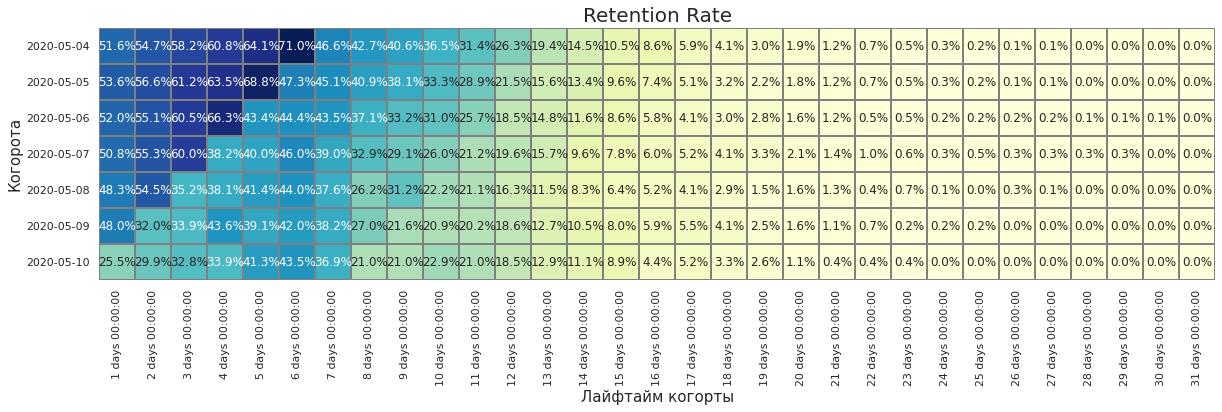

In [52]:
#передадим функцие параметры и визуализируем информацию
heatmap_create(result_grouped.iloc[:, 1:],'Retention Rate','Лайфтайм когорты','Когорота','.1%')

Во всех когортах наблюдается повышение возврата игроков в течение первой недели, затем следует спад. 10 мая прослеживается четкая граница повышенного возврата игроков, это можно объяснить концом марктинговой кампании и концом недели. 11 мая 2020 года (понедельник) показатели резко проседают. Также можно отметить, что игроки первых когорт сильнее "удерживаются" нежели последних, т.е. для когорт наблюдается тенденция: чем позже пришел игрок, тем меньше он заинтересован в игре. Или же можно судить, что игроки первых когорт дольше проходят уровень (в среднем у нас выходило 11 дней), а игроки последних когорт предпочитают быстро "пробежать" уровень.

### LTV

LTV, или Lifetime Value, — это «пожизненная ценность» клиента, то есть общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. Определим этот показатель. По условию, за каждый просмотр рекламы (при постройке здания), мы будем получать 0,07$.

In [53]:
#добавим столбец с доходом от просмотра рекламы
game_actions['revenue'] = game_actions['event'].apply(lambda x:.07 if x == 'building' else 0)

In [54]:
#добавим к таблице источник, откуда пришле игрок
game_actions = pd.merge(game_actions, user_source, on='user_id')

In [55]:
#получаем таблицу с user_id, event_datetime, revenue
orders = game_actions[['source', 'user_id', 'event_datetime', 'revenue']].copy()

In [56]:
#оставим в таблице данные, где был просмотр рекламы
orders = orders[orders['revenue'] > 0]

In [57]:
#получаем день показа рекламы
orders['ads_day'] = orders['event_datetime'].dt.date
orders = orders.rename(columns={'user_id':'uid'})
orders.head()

,source,uid,event_datetime,revenue,ads_day
0,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04 00:00:01,0.07,2020-05-04
1,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-05 05:20:15,0.07,2020-05-05
2,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-05 19:24:02,0.07,2020-05-05
3,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-05 20:59:19,0.07,2020-05-05
4,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-06 00:52:56,0.07,2020-05-06


In [58]:
#получаем день первого показа каждого игрока
first_orders = orders.groupby(['source', 'uid']).agg({'ads_day': 'min'}).reset_index()
first_orders.columns = ['source', 'uid', 'first_ads_day']
print(first_orders.head()) 

         source                                   uid first_ads_day
0  facebook_ads  0001f83c-c6ac-4621-b7f0-8a28b283ac30    2020-05-06
1  facebook_ads  002f508f-67b6-479f-814b-b05f00d4e995    2020-05-05
2  facebook_ads  004074f8-251a-4776-922c-8348dca1a2f6    2020-05-04
3  facebook_ads  00440efd-aa50-4b4b-aae8-ffcd1782729d    2020-05-04
4  facebook_ads  00965328-5e54-453f-b11b-52f8ae9ae80b    2020-05-07


In [59]:
#посчитаем количество уникальных просмотров рекламы
cohort_sizes = (
    first_orders.groupby(['source', 'first_ads_day'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['source', 'first_ads_day', 'user_ads']
print(cohort_sizes.head()) 

         source first_ads_day  user_ads
0  facebook_ads    2020-05-04      1184
1  facebook_ads    2020-05-05       694
2  facebook_ads    2020-05-06       345
3  facebook_ads    2020-05-07       224
4  facebook_ads    2020-05-08       139


In [60]:
#добавляем день первый рекламы каждого игрока в таблицу 
orders_new = pd.merge(orders,first_orders, on=['uid', 'source'])
orders_new.head()

,source,uid,event_datetime,revenue,ads_day,first_ads_day
0,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04 00:00:01,0.07,2020-05-04,2020-05-04
1,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-05 05:20:15,0.07,2020-05-05,2020-05-04
2,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-05 19:24:02,0.07,2020-05-05,2020-05-04
3,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-05 20:59:19,0.07,2020-05-05,2020-05-04
4,youtube_channel_reklama,55e92310-cb8e-4754-b622-597e124b03de,2020-05-06 00:52:56,0.07,2020-05-06,2020-05-04


In [61]:
#сгруппируем таблицу заказов по первому дню и дню каждого показа рекламы, сложим сумму
cohorts = (
    orders_new.groupby(['source', 'first_ads_day', 'ads_day'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
print(cohorts.head()) 

         source first_ads_day     ads_day  revenue
0  facebook_ads    2020-05-04  2020-05-04   115.99
1  facebook_ads    2020-05-04  2020-05-05    61.11
2  facebook_ads    2020-05-04  2020-05-06    69.37
3  facebook_ads    2020-05-04  2020-05-07    72.24
4  facebook_ads    2020-05-04  2020-05-08    83.16


In [62]:
#добавим в таблицу данные сколько игроков смотрели рекламу по дням
report = pd.merge(cohort_sizes, cohorts, on=['source', 'first_ads_day'])
report.head()

,source,first_ads_day,user_ads,ads_day,revenue
0,facebook_ads,2020-05-04,1184,2020-05-04,115.99
1,facebook_ads,2020-05-04,1184,2020-05-05,61.11
2,facebook_ads,2020-05-04,1184,2020-05-06,69.37
3,facebook_ads,2020-05-04,1184,2020-05-07,72.24
4,facebook_ads,2020-05-04,1184,2020-05-08,83.16


In [63]:
#определим срок когорты
report['day'] = (
    report['ads_day'] - report['first_ads_day']
) / np.timedelta64(1, 'D')
report['day'] = report['day'].astype('int')
report.head()

,source,first_ads_day,user_ads,ads_day,revenue,day
0,facebook_ads,2020-05-04,1184,2020-05-04,115.99,0
1,facebook_ads,2020-05-04,1184,2020-05-05,61.11,1
2,facebook_ads,2020-05-04,1184,2020-05-06,69.37,2
3,facebook_ads,2020-05-04,1184,2020-05-07,72.24,3
4,facebook_ads,2020-05-04,1184,2020-05-08,83.16,4


In [64]:
#подсчитаем прибыль для каждого источника
source_revenue=report.groupby('source').agg({'revenue': 'sum'}).reset_index()
source_revenue

,source,revenue
0,facebook_ads,"1,829.17"
1,instagram_new_adverts,"2,227.05"
2,yandex_direct,"3,152.24"
3,youtube_channel_reklama,"1,748.46"


In [65]:
#находим LTV
report['ltv'] = report['revenue'] / report['user_ads']

In [66]:
#представим данные в виде сводной таблицы
pivot_ltv = report.pivot_table(
    index='first_ads_day', columns='day', values='ltv', aggfunc='mean'
).round(3).cumsum(axis=1)
pivot_ltv

day,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
first_ads_day,,,,,,,,,,,,,,,,,,,,,
2020-05-04,0.10,0.15,0.21,0.27,0.34,0.41,0.49,0.53,0.57,0.61,...,0.72,0.72,0.72,0.72,0.72,0.72,0.72,NaN,0.72,0.72
2020-05-05,0.10,0.15,0.21,0.28,0.35,0.43,0.47,0.51,0.55,0.58,...,0.68,0.68,0.68,0.68,0.68,0.68,0.68,NaN,NaN,NaN
2020-05-06,0.10,0.15,0.21,0.27,0.35,0.39,0.43,0.47,0.50,0.53,...,0.62,0.62,0.62,0.62,0.62,0.62,0.62,NaN,0.62,NaN
2020-05-07,0.10,0.15,0.21,0.27,0.31,0.34,0.38,0.42,0.45,0.47,...,0.56,0.56,0.56,0.56,0.56,0.56,0.56,0.56,NaN,NaN
2020-05-08,0.09,0.14,0.20,0.23,0.26,0.29,0.34,0.37,0.39,0.42,...,0.49,0.49,0.50,NaN,0.50,NaN,NaN,NaN,NaN,NaN
2020-05-09,0.09,0.14,0.16,0.19,0.23,0.26,0.30,0.33,0.36,0.38,...,0.46,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-10,0.09,0.11,0.13,0.16,0.19,0.23,0.26,0.29,0.31,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


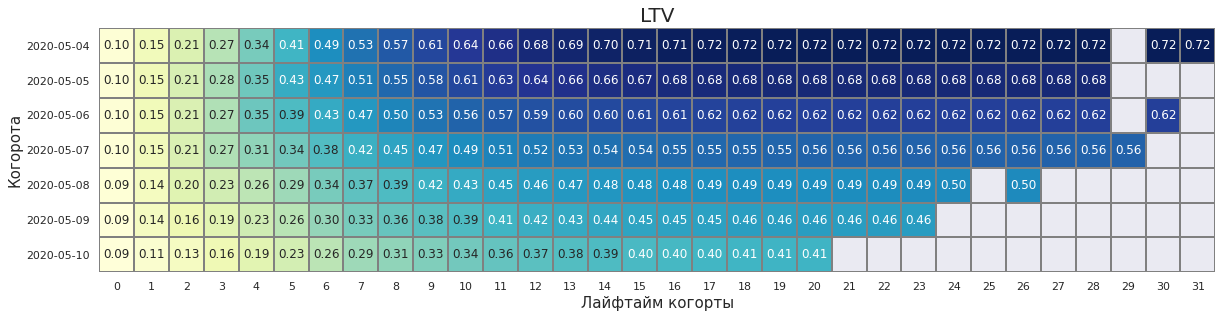

In [67]:
#визуализируем через функцию
heatmap_create(pivot_ltv,'LTV','Лайфтайм когорты','Когорота', '.2f')

Как видно из визуализации, показатель LTV больше всего у игроков, пришедших 2020-05-04, похожим поведением обладают и следующие когороты по 2020-05-07. Лишь три когорты с 2020-05-08 по 2020-05-10 очень долго "раскачиваются" и не не достигают показателей предыдущих. Рассмотрим этот показатель, применительно к источникам.

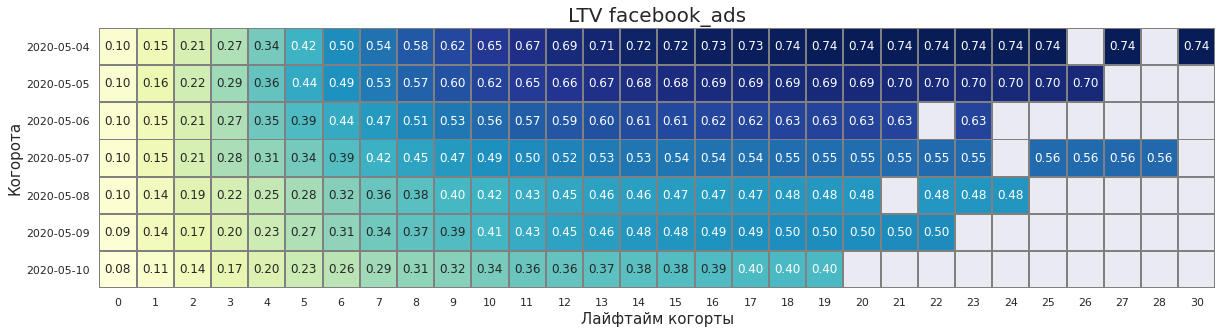

In [68]:
#визуализация LTV для facebook_ads
heatmap_create(report.query('source == "facebook_ads"')\
               .pivot_table(index='first_ads_day',columns='day', values='ltv', aggfunc='mean')\
               .round(3).cumsum(axis=1),'LTV facebook_ads','Лайфтайм когорты','Когорота', '.2f')

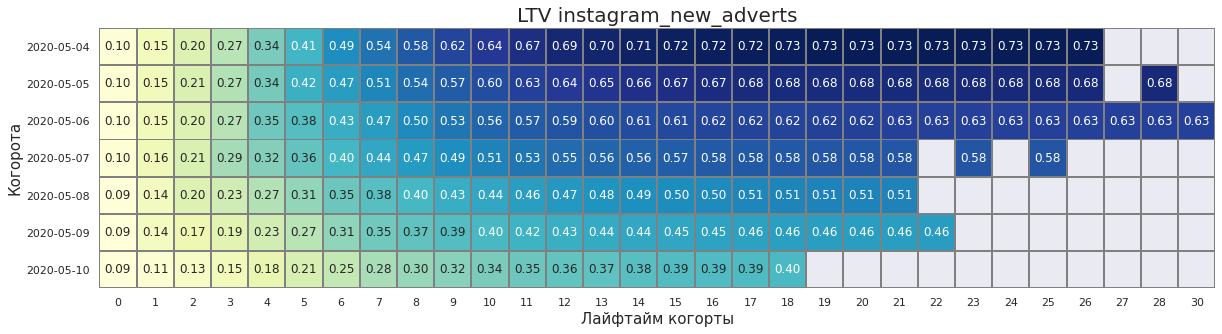

In [69]:
#визуализация LTV для instagram_new_adverts
heatmap_create(report.query('source == "instagram_new_adverts"').\
               pivot_table(index='first_ads_day', columns='day', values='ltv', aggfunc='mean').\
               round(3).cumsum(axis=1),'LTV instagram_new_adverts','Лайфтайм когорты','Когорота', '.2f')

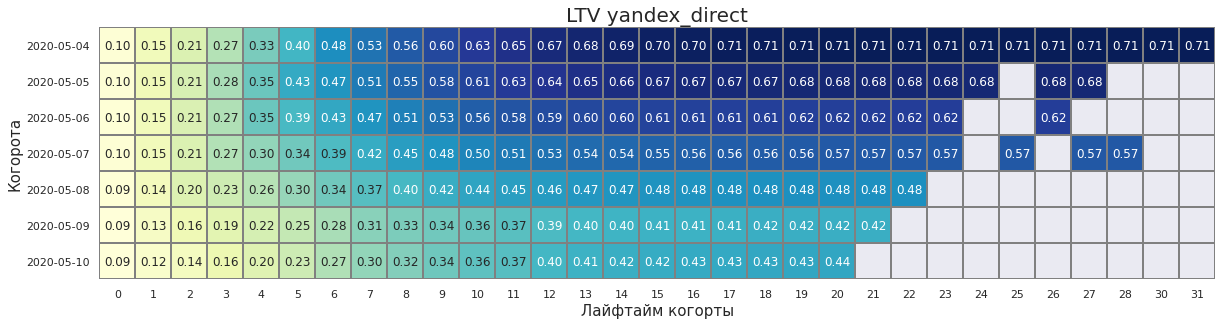

In [70]:
#визуализация LTV для yandex_direct
heatmap_create(report.query('source == "yandex_direct"').\
               pivot_table(index='first_ads_day', columns='day', values='ltv', aggfunc='mean').\
               round(3).cumsum(axis=1),'LTV yandex_direct','Лайфтайм когорты','Когорота', '.2f')

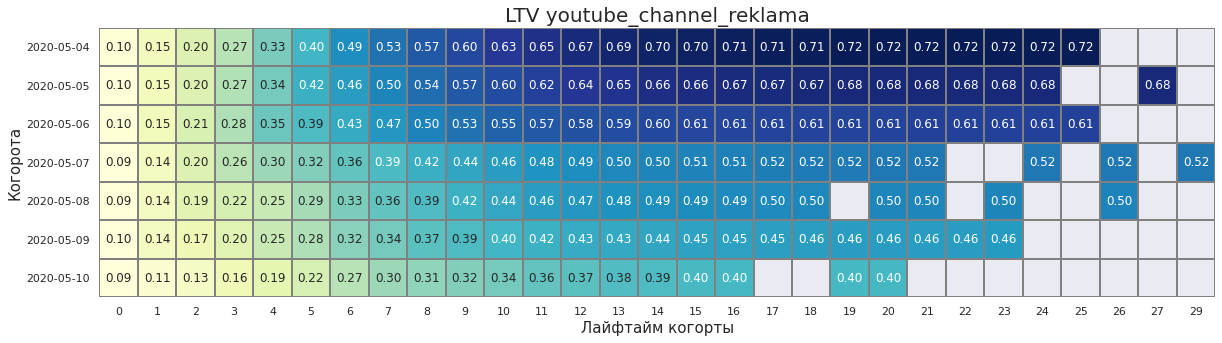

In [71]:
#визуализация LTV для youtube_channel_reklama
heatmap_create(report.query('source == "youtube_channel_reklama"').\
               pivot_table(index='first_ads_day', columns='day', values='ltv', aggfunc='mean').\
               round(3).cumsum(axis=1),'LTV youtube_channel_reklama','Лайфтайм когорты','Когорота', '.2f')

Показатели LTV на общем графике в общем виде не отличаются от таковых по источникам. Наши когороты условно можно поделить на две группы, первая 2020-05-04 по 2020-05-07 и вторая - 2020-05-08 по 2020-05-10. Так у первой довольно высокие показатели и набирают они их достаточно быстро, вторая группа очень долго "раскачиваются" и не достигает показателей предыдущих.

В рамках нашей модели монетизации мы заработали в общем - 8956,92$. Из них по источникам:
* facebook_ads - 1,829.17;
* instagram_new_adverts - 2,227.05;
* yandex_direct - 3,152.24;
* youtube_channel_reklama - 1,748.46

### CAC

CAC, или Customer Acquisition Cost, — стоимость привлечения одного клиента. Сумма денег, в которую компании обходится каждый новый клиент. В сущности, CAC — это инвестиции в маркетинг. Прежде чем определить этот показатель, проанализируем источники привлечения. Для начала найдем даты, с которых началось маркетинговое мероприятие, и когда оно закончилось. 

In [72]:
print('Минимальная дата:',ad_cost['day'].min())
print('Максимальная дата:',ad_cost['day'].max())

Минимальная дата: 2020-05-03 00:00:00
Максимальная дата: 2020-05-09 00:00:00


Маркетинговая кампания началась и закончилась раньше, так мы имеем данные о пользователях с 4 до 10 мая включительно, а маркетинговые данные у нас с 3 по 9 мая.

Сформируем сводную таблицу по источникам привлечения, рассчитаем количество привлеченных игроков, затраты на источник и стоимость одного привлечения.

In [73]:
#сформируем сводную таблицу по рекламным источникам
source_user_cost=user_source.groupby('source', as_index=False).agg({'user_id':'count'})\
.merge(ad_cost.groupby('source', as_index=False).agg({'cost':'sum'}),on='source',how='left')

#добавим расчет цены привлечения одного игрока
source_user_cost['user_value']=source_user_cost['cost']/source_user_cost['user_id'] 

In [74]:
#отобразим сводную таблицу по источникам/количеству привлеченных игроков/затрат на источник
source_user_cost

,source,user_id,cost,user_value
0,facebook_ads,2726,"2,140.90",0.79
1,instagram_new_adverts,3347,"2,161.44",0.65
2,yandex_direct,4817,"2,233.11",0.46
3,youtube_channel_reklama,2686,"1,068.12",0.40


In [75]:
#средние затраты на источник
source_user_cost['cost'].mean()

1900.8942466970057

In [76]:
#подсчитаем общее количество игроков
print('Общие затраты составляют: {:.2f}'.format(source_user_cost.iloc[0]['cost']+\
                                               source_user_cost.iloc[1]['cost']+\
                                               source_user_cost.iloc[2]['cost']+\
                                                source_user_cost.iloc[3]['cost']))

Общие затраты составляют: 7603.58


Общие затраты на рекламную кампанию составляют - 7603,58 у.е. Средние затраты на один источник составляют - 1900.89. Визуализируем информацию по затратам на привлечение по источникам.

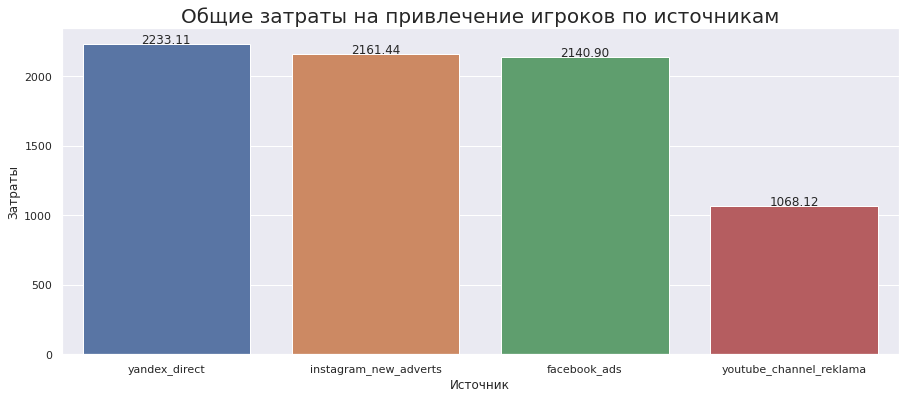

In [77]:
#функцие отправим данные для визуализации
barplot_create('source','cost',source_user_cost.sort_values(by='cost', ascending = False),\
               'Общие затраты на привлечение игроков по источникам','Источник','Затраты',1,0)

Из визуализации можно подметить, что по сути мы вкладывались в три источника `yandex_direct`, `instagram_new_adverts`, `facebook_ads`, половину затрат от лидирующих составляет `youtube_channel_reklama`. Лидером по количеству затрат является `yandex_direct` - 2233,11, `instagram_new_adverts` - 2161,44, `facebook_ads` - 2140,90, `youtube_channel_reklama` - 1068,12.

In [78]:
#сформируем сводную таблицу по дням и рекламным источникам
cost_day=ad_cost.pivot_table(index='day', columns='source', values='cost', aggfunc='sum')

In [79]:
#выведем на экран
cost_day

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-03,935.88,943.20,969.14,454.22
2020-05-04,548.35,502.93,554.65,259.07
2020-05-05,260.19,313.97,308.23,147.04
2020-05-06,177.98,173.07,180.92,88.51
2020-05-07,111.77,109.92,114.43,55.74
2020-05-08,68.01,71.58,62.96,40.22
2020-05-09,38.72,46.78,42.78,23.31


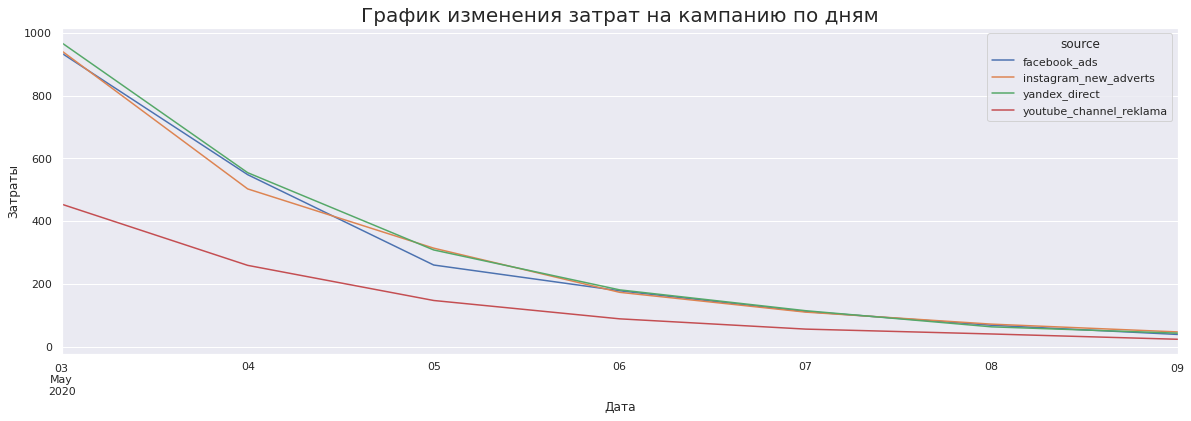

In [80]:
#визуализируем график изменения затрат по дням
cost_day.plot(figsize=(20, 6), grid=True, rot=0, legend=True)
#plt.yticks(np.arange(0, 650, 50))
plt.title('График изменения затрат на кампанию по дням', fontsize = 20)
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

В подтверждение визуализации, видно, что упор делеается на 3 канала, затраты на привлечение (во времени) у них схожие, лишь с незначительными отличиями. Однако, можно отметить что пик затрат пришелся на начало кампании (03 мая) и планомерно снижался к 9 мая. Каких-либо аномальных всплесков или падений, не наблюдается.

Подсчитаем количество привлеченных игроков по источникам, для этого обратимся к ранее созданной сводной таблице.

In [81]:
#сводная таблица по источникам привлечения
source_user_cost

,source,user_id,cost,user_value
0,facebook_ads,2726,"2,140.90",0.79
1,instagram_new_adverts,3347,"2,161.44",0.65
2,yandex_direct,4817,"2,233.11",0.46
3,youtube_channel_reklama,2686,"1,068.12",0.40


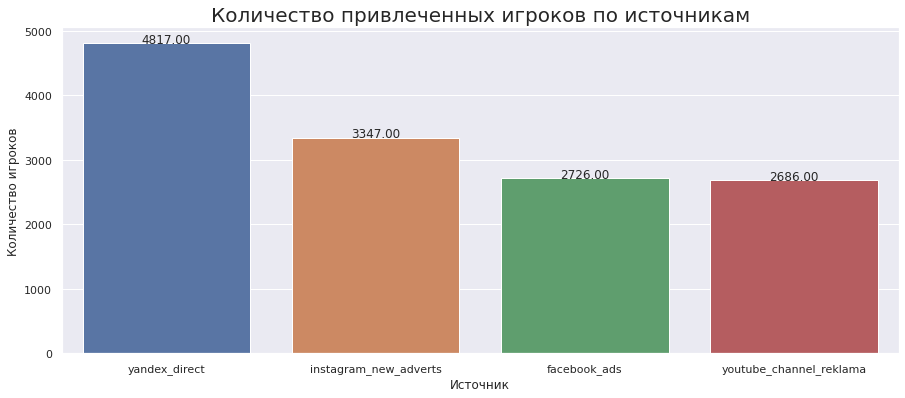

In [82]:
#функцие отправим данные для визуализации
barplot_create('source','user_id',source_user_cost.sort_values(by='user_id', ascending = False),\
               'Количество привлеченных игроков по источникам','Источник','Количество игроков',1,0)

Диаграмма показывает, среди источников, больше всего игроков привлек канал `yandex_direct` - 4817 игроков, меньше `instagram_new_adverts` - 3347 игрока, а `facebook_ads` и `youtube_channel_reklama` практически одинаковое количество - 2726 и 2686 соответственно.

Подсчитаем среднее количество привлеченных игроков

In [83]:
#среднее количество привлеченнеых игроков на канал
source_user_cost[['user_id']].mean()

user_id   3,394.00
dtype: float64

Среднее количество привлченных игроков составляет - 3394 игрока.

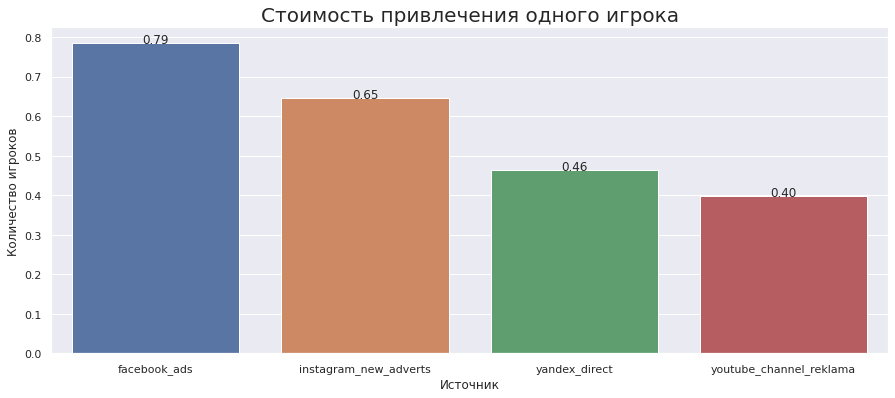

In [84]:
#функцие отправим данные для визуализации
barplot_create('source','user_value',source_user_cost.sort_values(by='user_value', ascending = False),\
               'Стоимость привлечения одного игрока', 'Источник','Количество игроков',0,0)

График показывает, что самое дорогое привлечение у `facebook_ads` - 0,79 за одного игрока, `instagram_new_adverts` - 0,65б `yandex_direct` - 0,46 , самое недорогое получилось у `youtube_channel_reklama` - 0,40.

In [85]:
#средняя стоимость привлечения одного ирока
source_user_cost['user_value'].mean()

0.5731002471448883

Проанализировав источники, сгруппируем затраты  по источнику и дню недели, чтобы в дальнейшем влитьв одну большую таблицу с расчетами. Не будем забывать, что у нас имеется сдвиг дат, маркетинговой и пользовательской, дабы не терять полноту анализа, сдвинем дату затрат на сутки.

In [86]:
#считаем расходы за день
week_costs = ad_cost.groupby(['source', 'day']).sum().reset_index()
report['first_ads_day'] =pd.to_datetime(report.first_ads_day, format='%Y-%m-%d')
week_costs['day']=pd.to_datetime(pd.to_datetime(week_costs.day, format='%Y-%m-%d')+datetime.timedelta(days=1))

In [87]:
#"поправим" формат даты для успешного слияния
week_costs['day'] = week_costs['day'].dt.strftime('%Y-%m-%d')
report['first_ads_day'] = report['first_ads_day'].dt.strftime('%Y-%m-%d')

In [88]:
#добавим данные о расходах в отчёт и посчитаем CAC
report_new = pd.merge(report, week_costs, left_on=['source', 'first_ads_day'], right_on=['source', 'day'])
report_new['cac'] = report_new['cost'] / report_new['user_ads']
report_new.head() 

,source,first_ads_day,user_ads,ads_day,revenue,day_x,ltv,day_y,cost,cac
0,facebook_ads,2020-05-04,1184,2020-05-04,115.99,0,0.10,2020-05-04,935.88,0.79
1,facebook_ads,2020-05-04,1184,2020-05-05,61.11,1,0.05,2020-05-04,935.88,0.79
2,facebook_ads,2020-05-04,1184,2020-05-06,69.37,2,0.06,2020-05-04,935.88,0.79
3,facebook_ads,2020-05-04,1184,2020-05-07,72.24,3,0.06,2020-05-04,935.88,0.79
4,facebook_ads,2020-05-04,1184,2020-05-08,83.16,4,0.07,2020-05-04,935.88,0.79


In [89]:
#сделаем небольшую сводную таблицу
source_user_cost.columns = ['source','gamer','cost','cac']
source_user_cost

,source,gamer,cost,cac
0,facebook_ads,2726,"2,140.90",0.79
1,instagram_new_adverts,3347,"2,161.44",0.65
2,yandex_direct,4817,"2,233.11",0.46
3,youtube_channel_reklama,2686,"1,068.12",0.40


В общем на рекламную кампанию мы затратили 7603,58$. В основном траты шли на три источника - `yandex_direct` (2233,11), `instagram_new_adverts` (2161,44), `facebook_ads`(2140,90), меньше всего на `youtube_channel_reklama`(1068,12).

Подсчитав количество привлеченных пользователей и затраты, мы выявили стоимость привлечения одного игрока у каждого иисточника. Оно оказалось таким, у `facebook_ads` - 0,79 , `instagram_new_adverts` - 0,65, `yandex_direct` - 0,46 , самое недорогое (и наиболее выгодное) получилось у `youtube_channel_reklama` - 0,40.

### ROMI

ROMI, или Return On Marketing Investment, — окупаемость инвестиций. В экономике одного покупателя эта метрика показывает, на сколько процентов LTV превысил CAC. Ещё говорят: на сколько процентов «окупились» клиенты. Подсчитаем этот показатель и визуализируем.

In [90]:
#подсчитаем ROMI
report_new['romi'] = report_new['ltv'] / report_new['cac'].shift(periods=1)

In [91]:
#создадим сводную таблицу по показателям
pivot_romi = report_new.pivot_table(
        index='first_ads_day', columns='day_x', values='romi', aggfunc='mean'
    ).cumsum(axis=1)    

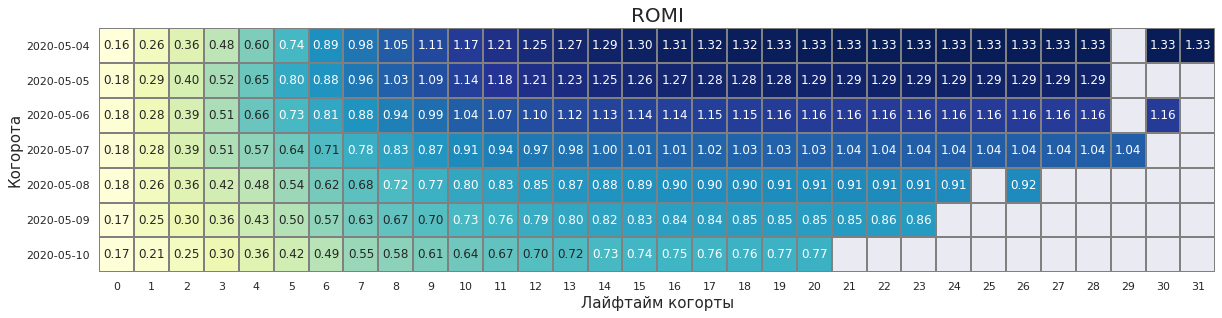

In [92]:
#визуаулизируем сводную таблицу
heatmap_create(pivot_romi,'ROMI','Лайфтайм когорты','Когорота', '.2f')

Также можно отметить схожесть некоторых когорт, но лидерство по окупаемости (и по скорости) можно отдать двум когортам 2020-05-04 и 2020-05-05. Печально с окупаемостью к двух последних когорот (2020-05-08 и 2020-05-10). Мало того, что показатели ниже первых когорот, так и скорость уступает им же. 

Рассмотрим этот же показатель, но уже в разрезе источников. Тут должны быть сюрпризы.

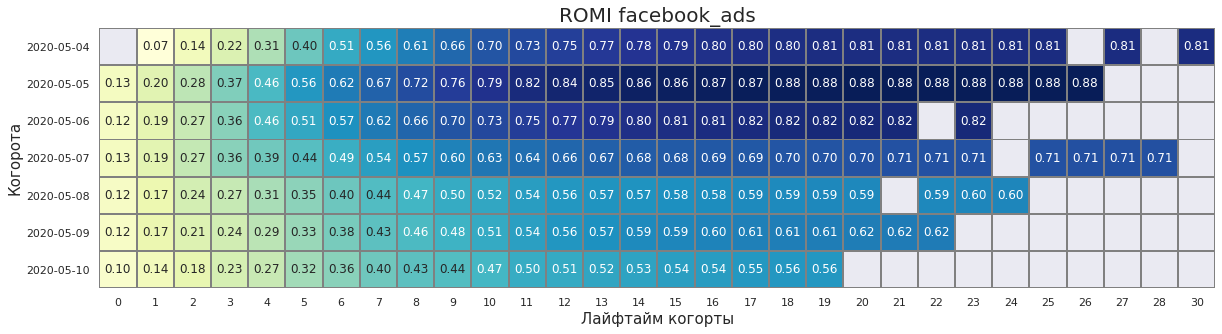

In [93]:
#визуализация ROMI для facebook_ads
heatmap_create(report_new.query('source == "facebook_ads"').pivot_table(
        index='first_ads_day', columns='day_x', values='romi', aggfunc='mean'
    ).cumsum(axis=1),'ROMI facebook_ads','Лайфтайм когорты','Когорота', '.2f')

Сделаем заключение по когоротам:
* ❌2020-05-04 - затраты не окупились, но показатель был близок к границе окупаемости;;
* ❌2020-05-05 - затраты не окупились, но показатель был близок к границе окупаемости;;
* ❌2020-05-06 - затраты не окупились, но показатель был близок к границе окупаемости;
* ❌2020-05-07 - затраты не окупились;
* ❌2020-05-08 - затраты не окупились;
* ❌2020-05-09 - затраты не окупились;
* ❌2020-05-10 - затраты вообще не окупились

ни в одной из когорт затраты не окупились.

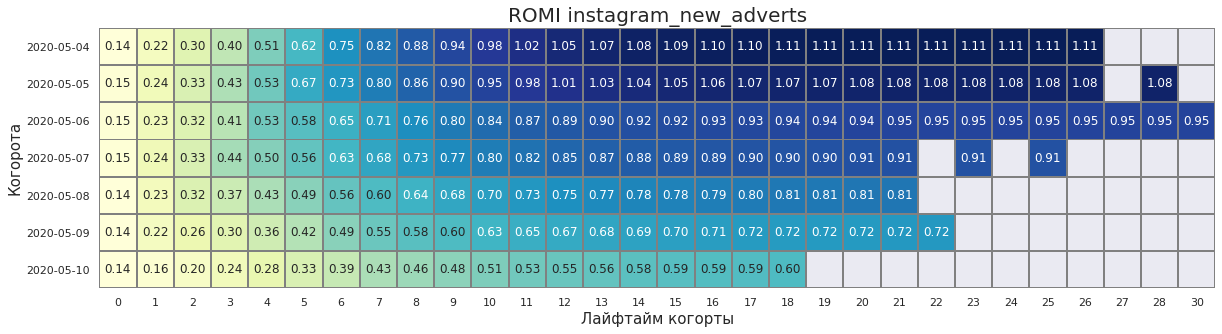

In [94]:
#визуализация ROMI для instagram_new_adverts
heatmap_create(report_new.query('source == "instagram_new_adverts"').pivot_table(
        index='first_ads_day', columns='day_x', values='romi', aggfunc='mean'
    ).cumsum(axis=1),'ROMI instagram_new_adverts','Лайфтайм когорты','Когорота', '.2f')

Сделаем заключение по когоротам:
* ✅2020-05-04 - затраты окупились;
* ✅2020-05-05 - затраты окупились;
* ✅2020-05-06 - затраты полностью не окупились, но значение пограничное;
* ❌2020-05-07 - затраты полностью не окупились, но значение пограничное;
* ❌2020-05-08 - затраты не окупились;
* ❌2020-05-09 - затраты не окупились;
* ❌2020-05-09 - затраты вообще не окупились.

так из 7 когорт, окупились 3.

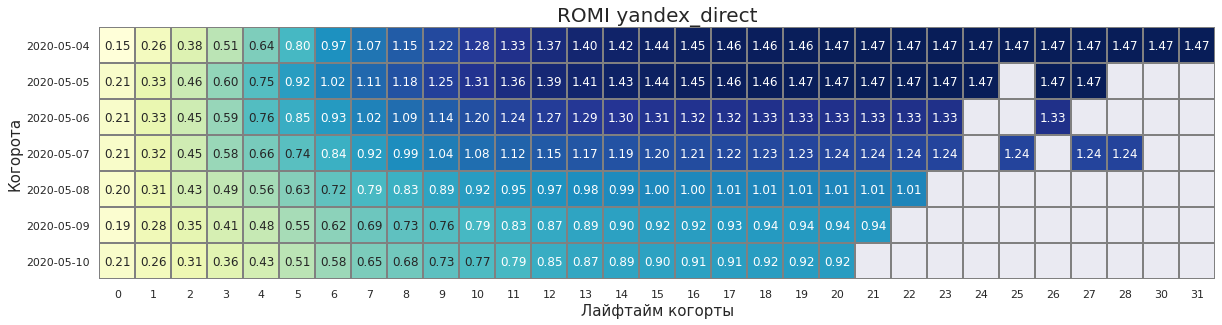

In [95]:
#визуализация ROMI для yandex_direct
heatmap_create(report_new.query('source == "yandex_direct"').pivot_table(
        index='first_ads_day', columns='day_x', values='romi', aggfunc='mean'
    ).cumsum(axis=1),'ROMI yandex_direct','Лайфтайм когорты','Когорота', '.2f')

Сделаем заключение по когоротам:
* ✅2020-05-04 - затраты окупились хорошо;
* ✅2020-05-05 - затраты окупились хорошо;
* ✅2020-05-06 - затраты окупились неплохо;
* ✅2020-05-07 - затраты окупились неплохо;
* ✅2020-05-08 - затраты окупились, но значение пограничное;
* ❌2020-05-09 - затраты не окупились, но значение пограничное;
* ❌2020-05-10 - затраты не окупились, но значение пограничное;

так из 7 когорт, окупились 5.

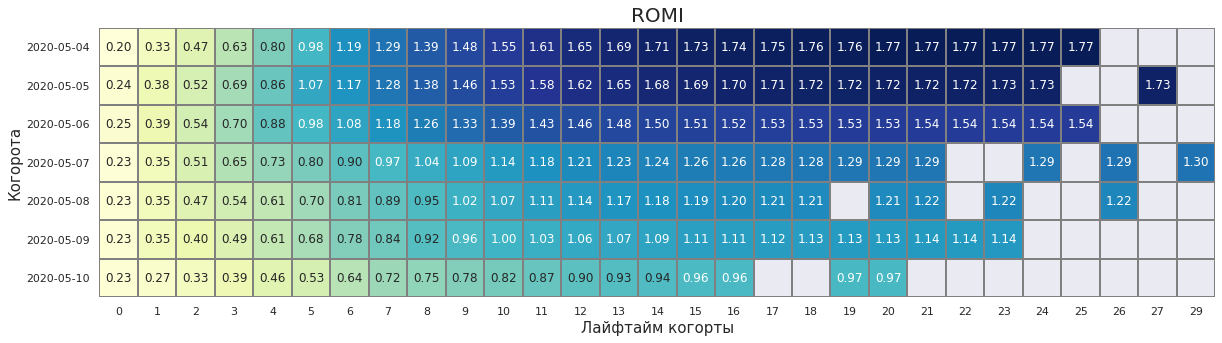

In [96]:
#визуализация ROMI для youtube_channel_reklama
heatmap_create(report_new.query('source == "youtube_channel_reklama"').pivot_table(
        index='first_ads_day', columns='day_x', values='romi', aggfunc='mean'
    ).cumsum(axis=1),'ROMI','Лайфтайм когорты','Когорота', '.2f')

Сделаем заключение по когоротам:
* ✅2020-05-04 - затраты окупились превосходно;
* ✅2020-05-05 - затраты окупились превосходно;
* ✅2020-05-06 - затраты окупились отлично;
* ✅2020-05-07 - затраты окупились отлично;
* ✅2020-05-08 - затраты окупились хорошо;
* ✅2020-05-09 - затраты окупились неплохо;
* ✅2020-05-10 - затраты не окупились, но очень близки к границе;

так из 7 когорт, в целом можно сказать, что окупились все.

В общем окупаемость по затратам на маркетинговые источники была достигнута. Но если рассматривать показатели более детально, применительнок источникам, то выясняется, что не все так однозначно.
* `facebook_ads` - из 7 когорт, ни одна не окупилась;
* `instagram_new_adverts` - окупились лишь 3;
* `yandex_direct` - окупились 5;
* `youtube_channel_reklama` - тут можно сказать, что окупились практически все когороты.

Выбор источника трафика сильно влияет на прибыль от игры, при планировании модели маркетинга необходимо обязательно учесть этот фактор.

### Вывод

**Игроки**

В нашей мобильной игре мы насчитали 13576 игроков. Меньше половины (42,85%) от общего числа прошли 1 уровень. Любимая стратегия выигрыша - победа над врагом (3951 против 1866).

**Время прохождения уровня**

Самое быстрое прохождение уровня было за 9 часов 39 минут, самое долгое - 30 дней 21 час 58 минут. Но обычным можно считать то, которое занимает в среднем 11 дней 20 часов 37 минут. Но время прохождения меняется в зависимости от выбранной стратегии победы.

**Количество построек**

Преобладающей постройкой в нашей игре является `spaceport` (59352 строений), затем `assembly_shop` (54494 строений), меньше всего игроки строили `research_center` (14137).


**DAU, WAU,Sticky Factor**

В среднем, каждый день мы наблюдали **2884.88** уникальных игроков, в неделю же их количество было на уровне **6120.00** игроков. Регулярность использования нашей игры находится на уровне **47.12%**.


**Retention Rate**

Во всех когортах наблюдается рост возврата игроков в течение первой недели, затем следует спад. Это может свидетельствоовать об активной маркетинговой кампании и ее прекращении. Из-за этого 10 числа наблюдается довольно четкая граница повышенного возврата игроков. Но также наблюдается тенденция: чем позже пришел пользователь, тем меньше он заинтересован в игре. Первые когорты активно задерживаются, нежели последние.


**LTV**

Как в общем виде, так в разрезе источников, показатели в одной поре. Наши когороты условно можно поделить на две группы, первая 2020-05-04 по 2020-05-07 и вторая - 2020-05-08 по 2020-05-10. Так у первой довольно высокие показатели и набирают они их достаточно быстро, вторая группа очень долго "раскачиваются" и не достигает показателей предыдущих.

**CAC**

За весь срок маркетинговой кампании (с 2020-05-03 по 2020-05-09) мы затратили 7603,58$. В основном траты шли на три источника - `yandex_direct` (2233,11), `instagram_new_adverts` (2161,44), `facebook_ads`(2140,90), меньше всего на `youtube_channel_reklama`(1068,12).

Расситали сколько стоит привлечение одого игрока, у `facebook_ads` стоит - 0,79 , `instagram_new_adverts` - 0,65, `yandex_direct` - 0,46 , самое недорогое (и наиболее выгодное) получилось у `youtube_channel_reklama` - 0,40.

**ROMI**

Из всех источников можно выделить `youtube_channel_reklama`, у него практически все когорты окупились вложенные затраты. Соврешенно не окупились затраты по когортам у источника `facebook_ads`. У остальных источников окупились 50% когорт и меньше.
Выбор источника трафика сильно влияет на прибыль от игры, при планировании модели маркетинга необходимо обязательно учесть этот фактор.

## Проверка гипотез

### Время прохождения уровней различается

Чтобы проверить данную гипотезу мы постраемся использовать t-критерий Стьюдента.На предудыщих шагах, мы увидели, как сильно разнится время прохождения уровня (от нескольких часов до одного месяца), это подразумевает под собой наличие большого количества выбросов. Помимо этого првоерим данные на "нормальность", выбросы - удалим.

In [97]:
#выделим количество дней в отдельную колонку в каждой таблице по способу прохождения
level_project['days_time']=level_project['level_time']/np.timedelta64(1, 'D')
level_enemy['days_time']=level_enemy['level_time']/np.timedelta64(1, 'D')

In [98]:
#соединим наши таблицы для сравнительной визуализации
win_result = pd.concat([level_project.drop(columns=['user_id_']), level_enemy.drop(columns=['user_id_'])])

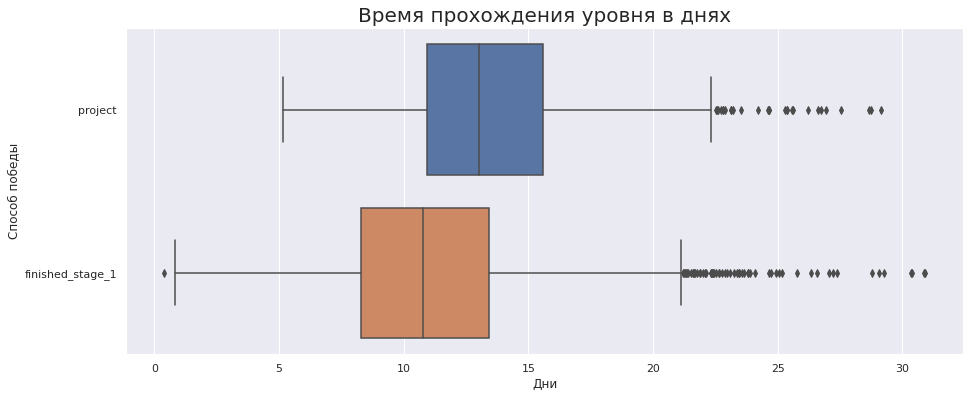

In [99]:
#визуализируем время прохождения
sns.boxplot(x='days_time',y='win',data=win_result)
plt.title('Время прохождения уровня в днях', fontsize = 20)
plt.ylabel('Способ победы')
plt.xlabel('Дни');

Как можно увидеть, как правило на заверешение уровня через победу над врагом треубуется меньше времени, однако у такого способа большое количество "выбросов" (на графике после 21 дня). У победы через проект, затрчиваевое время несколько больше, но "выбросов" значительно меньше. Такие выбросы могут повлиять на конечные результаты, поэтому проверим за какое максимальное время завершают уровень 95% игроков, остальное удалим.

Проверим распределение данных.

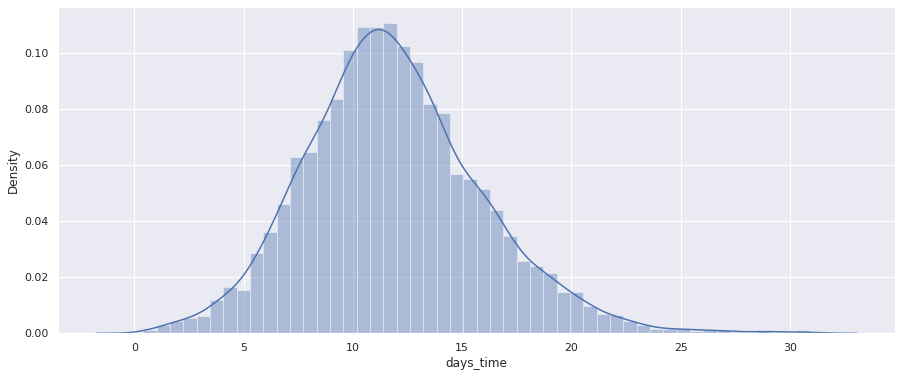

In [100]:
#визуализация распределения данных
sns.distplot(win_result['days_time'])
plt.show()

Данные распределены нормально, поэтому можем двигаться дальше.

In [101]:
#определим срок прохождения уровня
print('97% игроков завершают уровень за: {:.0f} дней через победу над врагом'.\
      format(np.percentile(level_enemy['days_time'], 97)))

97% игроков завершают уровень за: 20 дней через победу над врагом


In [102]:
#определим срок прохождения уровня
print('97% игроков завершают уровень за: {:.0f} дней через реализацию проекта'.\
      format(np.percentile(level_project['days_time'], 97)))

97% игроков завершают уровень за: 21 дней через реализацию проекта


In [103]:
#уберем данные и проверим "потери"
level_project_clear=level_project.query('21 >= days_time')
print('Потери данных составили (победа через проект): {:.2f}%'.\
      format((level_project.shape[0]-level_project_clear.shape[0])/level_project.shape[0]*100))

Потери данных составили (победа через проект): 3.16%


In [104]:
#уберем данные и проверим "потери"
level_enemy_clear=level_enemy.query('20 >= days_time > 1')
print('Потери данных составили (победа через врага): {:.2f}%'.\
      format((level_enemy.shape[0]-level_enemy_clear.shape[0])/level_project.shape[0]*100))

Потери данных составили (победа через врага): 5.73%


Перейдем к проверке гипотезы, для начала сформулириуем нулевую и альтернативную:

**H0** - среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над врагом, <font color="red">не различается</font>.

**H1** - среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над врагом, <font color="red">различается</font>.

Предварительно выясним, равна ли дисперсия этих двух выборок, т.к. размеры выборок отличаются.

In [105]:
#cравним дисперсии двух выборок
print('Значение дисперсии для выборки "победа над врагом": {:.2f}'.format(level_enemy_clear['days_time'].var()))
print('Значение дисперсии для выборки "проект": {:.2f}'.format(level_project_clear['days_time'].var()))

Значение дисперсии для выборки "победа над врагом": 13.38
Значение дисперсии для выборки "проект": 9.35


Так как дисперсия выборок отличается, то справедливо при анализе поставить параметр `equal_var=False`. Порогом примем 5%

In [106]:
alpha = 0.05
results = st.ttest_ind(level_enemy_clear['days_time'], level_project_clear['days_time'], equal_var=False)
print('p-значение: ', results.pvalue)
if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.7863691495089676e-129
Отвергаем нулевую гипотезу


Мы вынуждены отвернуть нулевую гипотезу, это значит, что в зависимости от выбора способа прохождения, изменяется и время прохождения 1 уровня. Если изначально так не было задумано, следует обратить на это внимание, т.к. нарушается внутриигровой баланс, что может сказаться на прибыли.

### Вовлеченность игроков не зависит от канала привлечения

Для начала определим, что понимаем под "вовлеченностью", под этим будем понимать заинтересованность игрока в игре. Определять мы будем эту заинтересованность (в рамках наших данных) по количеству событий.

In [107]:
#соберем наборы данных для проверки
facebook_ads = game_actions[game_actions['source'] == 'facebook_ads'].\
groupby('user_id').agg({'event_date':'nunique'})['event_date']

instagram_new_adverts = game_actions[game_actions['source'] == 'instagram_new_adverts'].\
groupby('user_id').agg({'event_date':'nunique'})['event_date']

yandex_direct= game_actions[game_actions['source'] == 'yandex_direct'].\
groupby('user_id').agg({'event_date':'nunique'})['event_date']

youtube_channel_reklama = game_actions[game_actions['source'] == 'youtube_channel_reklama'].\
groupby('user_id').agg({'event_date':'nunique'})['event_date']

Для проверки этой гипотезы мы воспользуемся U-критерием Манна-Уитни. U-критерий является непараметрическим критерием, поэтому, в отличие от t-критерия Стьюдента, не требует наличия нормального распределения сравниваемых совокупностей.

Перейдем к проверке гипотезы, для начала сформулириуем нулевую и альтернативную:

**H0** - вовлеченность игроков в игровой процесс, пришедших с разных источников привлечения <font color="red">не различается</font>.

**H1** - вовлеченность игроков в игровой процесс, пришедших с разных источников привлечения <font color="red">различается</font>.

Так как мы будем сравнивать множество пар, создадим функцию для проверки гипотезы

In [108]:
def mw_test(fisrt, second, title):
    print('Проверка гипотезы для пары:', title)
    print('\n')

    results = st.mannwhitneyu(fisrt, second)

    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha_mw:
        print('Отвергаем нулевую гипотезу')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу'
        )
    print('\n')

Т.к. мы будем проводить множественные сравнения между группами, то возникает групповая вероятность ошибки первого рода, или FWER (от англ. family-wise error rate, «групповой коэффициент ошибок»). Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости для уменьшения FWER.

Чаще всего применяют поправку Бонферрони — из-за простоты решения. Самая грубая и распространённая поправка к требуемым уровням значимости. Уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении. Проще говоря, делят уровень значимости ɑ на число гипотез.

In [109]:
#корректировка уровня
alpha_mw = .05 / 6

In [110]:
#проверка гипотезы для facebook_ads и instagram_new_adverts
mw_test(facebook_ads, instagram_new_adverts, 'facebook_ads и instagram_new_adverts')

Проверка гипотезы для пары: facebook_ads и instagram_new_adverts


p-значение:  0.839709297490919
Не получилось отвергнуть нулевую гипотезу




In [111]:
#проверка гипотезы для facebook_ads и yandex_direct
mw_test(facebook_ads, yandex_direct, 'facebook_ads и yandex_direct')

Проверка гипотезы для пары: facebook_ads и yandex_direct


p-значение:  0.11488827662014403
Не получилось отвергнуть нулевую гипотезу




In [112]:
#проверка гипотезы для facebook_ads и instagram_new_adverts
mw_test(facebook_ads, youtube_channel_reklama , 'facebook_ads и youtube_channel_reklama')

Проверка гипотезы для пары: facebook_ads и youtube_channel_reklama


p-значение:  0.04190944456895957
Не получилось отвергнуть нулевую гипотезу




In [113]:
#проверка гипотезы для instagram_new_adverts и yandex_direct
mw_test(instagram_new_adverts, yandex_direct, 'instagram_new_adverts и yandex_direct')

Проверка гипотезы для пары: instagram_new_adverts и yandex_direct


p-значение:  0.1511337370921817
Не получилось отвергнуть нулевую гипотезу




In [114]:
#проверка гипотезы для instagram_new_adverts и youtube_channel_reklama
mw_test(instagram_new_adverts, youtube_channel_reklama, 'instagram_new_adverts и youtube_channel_reklama')

Проверка гипотезы для пары: instagram_new_adverts и youtube_channel_reklama


p-значение:  0.053838081304046805
Не получилось отвергнуть нулевую гипотезу




In [115]:
#проверка гипотезы для yandex_direct и youtube_channel_reklama
mw_test(yandex_direct, youtube_channel_reklama, 'yandex_direct и youtube_channel_reklama')

Проверка гипотезы для пары: yandex_direct и youtube_channel_reklama


p-значение:  0.4672438210904456
Не получилось отвергнуть нулевую гипотезу




Ни в одном случае не удалось отпровергнуть гипотезу, это означает, что утверждение о равенстве средних в выборках справделиво. Можно заключить, что вовлеченность игрока (количество событий) никак не зависит от канала привлечения.

### Вывод

**Гипотеза об одинаковом времени прохождения**

Мы вынуждены отвернуть нулевую гипотезу, это значит, что в зависимости от выбора способа прохождения, изменяется и время прохождения 1 уровня. Если изначально так не было задумано, следует обратить на это внимание, т.к. нарушается внутриигровой баланс, что может сказаться на прибыли.

**Гипотеза о зависимости вовлеченности игроков от каналов привлечения**

Мы сравнили несколько пар данных с разных источников между собой и выяснили, что утверждение о равенстве средних в выборках справедливо, нулевая гипотеза подтвердилась. Различия во вовлеченности между игроками, которые пришли из различных источников привлечения - отсутствуют.

## Вывод и рекомендации

### Вывод

`facebook_ads` - самый невыгодный вариант. При больших затратах (2140,90) мы имеем небольшое количество привлеченных игроков (2726) и как следствие - самое дорогое привлечение за игрока. В рамках рассматриваемой модели монетизации, мы также имеем небольшую прибыль - 1,829.17. Это напрямую повлияло на показатели ROMI в когортах, так ни одна когорта из семи, не окупилась.

`instagram_new_adverts`  - тоже не самый выгодный вариант. Так из семи когорт, полностью окупились 2. Также при высоких затратах (2161 в общем и 0,65 на игрока), мы получим прибыль в размере - 2,227.05. В целом мы отобьем маркетинговые затраты, но получение прибыли растянется во времени.

`yandex_direct` - неплохой претендент на выгодный источник. При самых высоких затратах - 2233, мы привлкекли и самое большое колчиество игроков - 4817 (0,46 на одно игрока). Прибыль с источника составялет - 3,152.24, т.е. полностью перекрывает затраты. Но при когортном анализы, выявилось, что не все когорты полностью окупаются (окупаются 5 из 7).

`youtube_channel_reklama` - самый выгодный вариант. Помимо малых общих затрат (относительно других источников). При минимальных затратах (1068,12) мы привлекли 2686 игроков (0,40 на одного)! При этом получили прибыль в размере - 1,748.46. Из семи когорт - окупились все.



### Модель монетизации

В целом рассматриваемая модель монетизации имеет место быть:
* прибыль по итогам составила - 1353,34$;
* расходы на рекламу начинают окупаться с 7 дня (в зависимости от источника привлечения);
* LTV и ROMI сильно зависят от когорты, в первых когортах мы могли наблюдать хорошие показатели, а в последних - не выдерживающих критики;
* необходимо пересмотреть привлечение из источников `facebook_ads` и `instagram_new_adverts`.

**Альтернативный вариант монетизации**

Предложим альтернативный вариант, для этого воспользуемся данными из анализа. Мы подсчитали, что на привлечение одного игрока нам требуется 0,57, и что на одного игрока приходится 9 построек. По условию, за каждый просмотр рекламы, мы получаем 0,07. Определим, сколько раз игрок должен посмотреть рекламу для выхода в ноль.

In [116]:
#подсчет "точки безубыточности"
print('Игрок должен посмотреть рекламу {:.0f} раз, чтобы затраты на привлечение окупились'.format(
    source_user_cost['cac'].mean()/0.07))

Игрок должен посмотреть рекламу 8 раз, чтобы затраты на привлечение окупились


Т.е. средний игрок, окупает наши инвестиции в маркетинг и мы получаем небольшой доход. Допустим, рекламу будем показывать при постройке не начиная с первой постройки, а к примеру с третьей. Подсчитаем.

In [117]:
#вспомним общие затраты на продвижение
print('Общие затраты на продвижение составляют: {:.2f}'.format(source_user_cost.iloc[0]['cost']+\
                                               source_user_cost.iloc[1]['cost']+\
                                               source_user_cost.iloc[2]['cost']+\
                                                source_user_cost.iloc[3]['cost']))

Общие затраты на продвижение составляют: 7603.58


In [118]:
#рассчитаем доход при показе рекламы наичная с третьей постройки
event_model = game_actions.query('event=="building"').groupby('user_id').agg({'event':'count'}).reset_index()
event_model['income']= (event_model['event']-2)*0.07
event_model
print('Доход с показа рекламы, начиная с постройки третьего здания  составит: {:.2f}'.format(
    event_model['income'].sum()))

Доход с показа рекламы, начиная с постройки третьего здания  составит: 7056.28


При затратах на маркетинг в 7603,58 и таком доходе, долго мы не протянем. Поменяем условия и будем показывать рекламу, начиная со второй постройки.

In [119]:
#рассчитаем доход при показе рекламы наичная со второй постройки
event_model = game_actions.query('event=="building"').groupby('user_id').agg({'event':'count'}).reset_index()
event_model['income']= (event_model['event']-1)*0.07
event_model
print('Доход с показа рекламы с постройки третьего здания  составит: {:.2f}'.format(
    event_model['income'].sum()))

Доход с показа рекламы с постройки третьего здания  составит: 8006.60


In [120]:
#подсчитаем доход
print('Доход составит: {:.2f}'.format(event_model['income'].sum()-\
                                                (source_user_cost.iloc[0]['cost']+\
                                               source_user_cost.iloc[1]['cost']+\
                                               source_user_cost.iloc[2]['cost']+\
                                                source_user_cost.iloc[3]['cost'])))

Доход составит: 403.02


Т.е. как альтернативный и прибыльный вариант, можно рассматривать модель при которой, траты на привлечение, количество пользователей, удрежание и прочие показатели остаются неизменными. Но показ рекламы начинается с постройки втрого строения (если показывать на постройке третьего строения - мы не выйдем в плюс). Конечно, хотелось бы видеть другие способы монетизации (бустеры или уникальный контент) за просмотр рекламы, но это выходит за рамки наших компетенций.

Презентация:  <a href="https://disk.yandex.ru/i/2uOBfpC2-_Tejw">Находится тут</a>  <a href="https://drive.google.com/file/d/18OUm7vd8VVIuldWH5McdPMM6nCR5pIu7/view?usp=sharing"> или тут</a> 

<div class="alert alert-success">
<b> 🤌  Комментарий тимлида </b>  
    
Презентация буквально чудесная 🌟 
    
Очень удачное оформление, все по делу и без лишнего текста. 
    
    
Надеюсь там вскоре появятся слайды о моделях и я с удовольствием использую ее для доклада менеджеру продукта 👍
    
</div>